# RGB сlassification with KNN
### Подготовил: Степанюк Денис Борисович
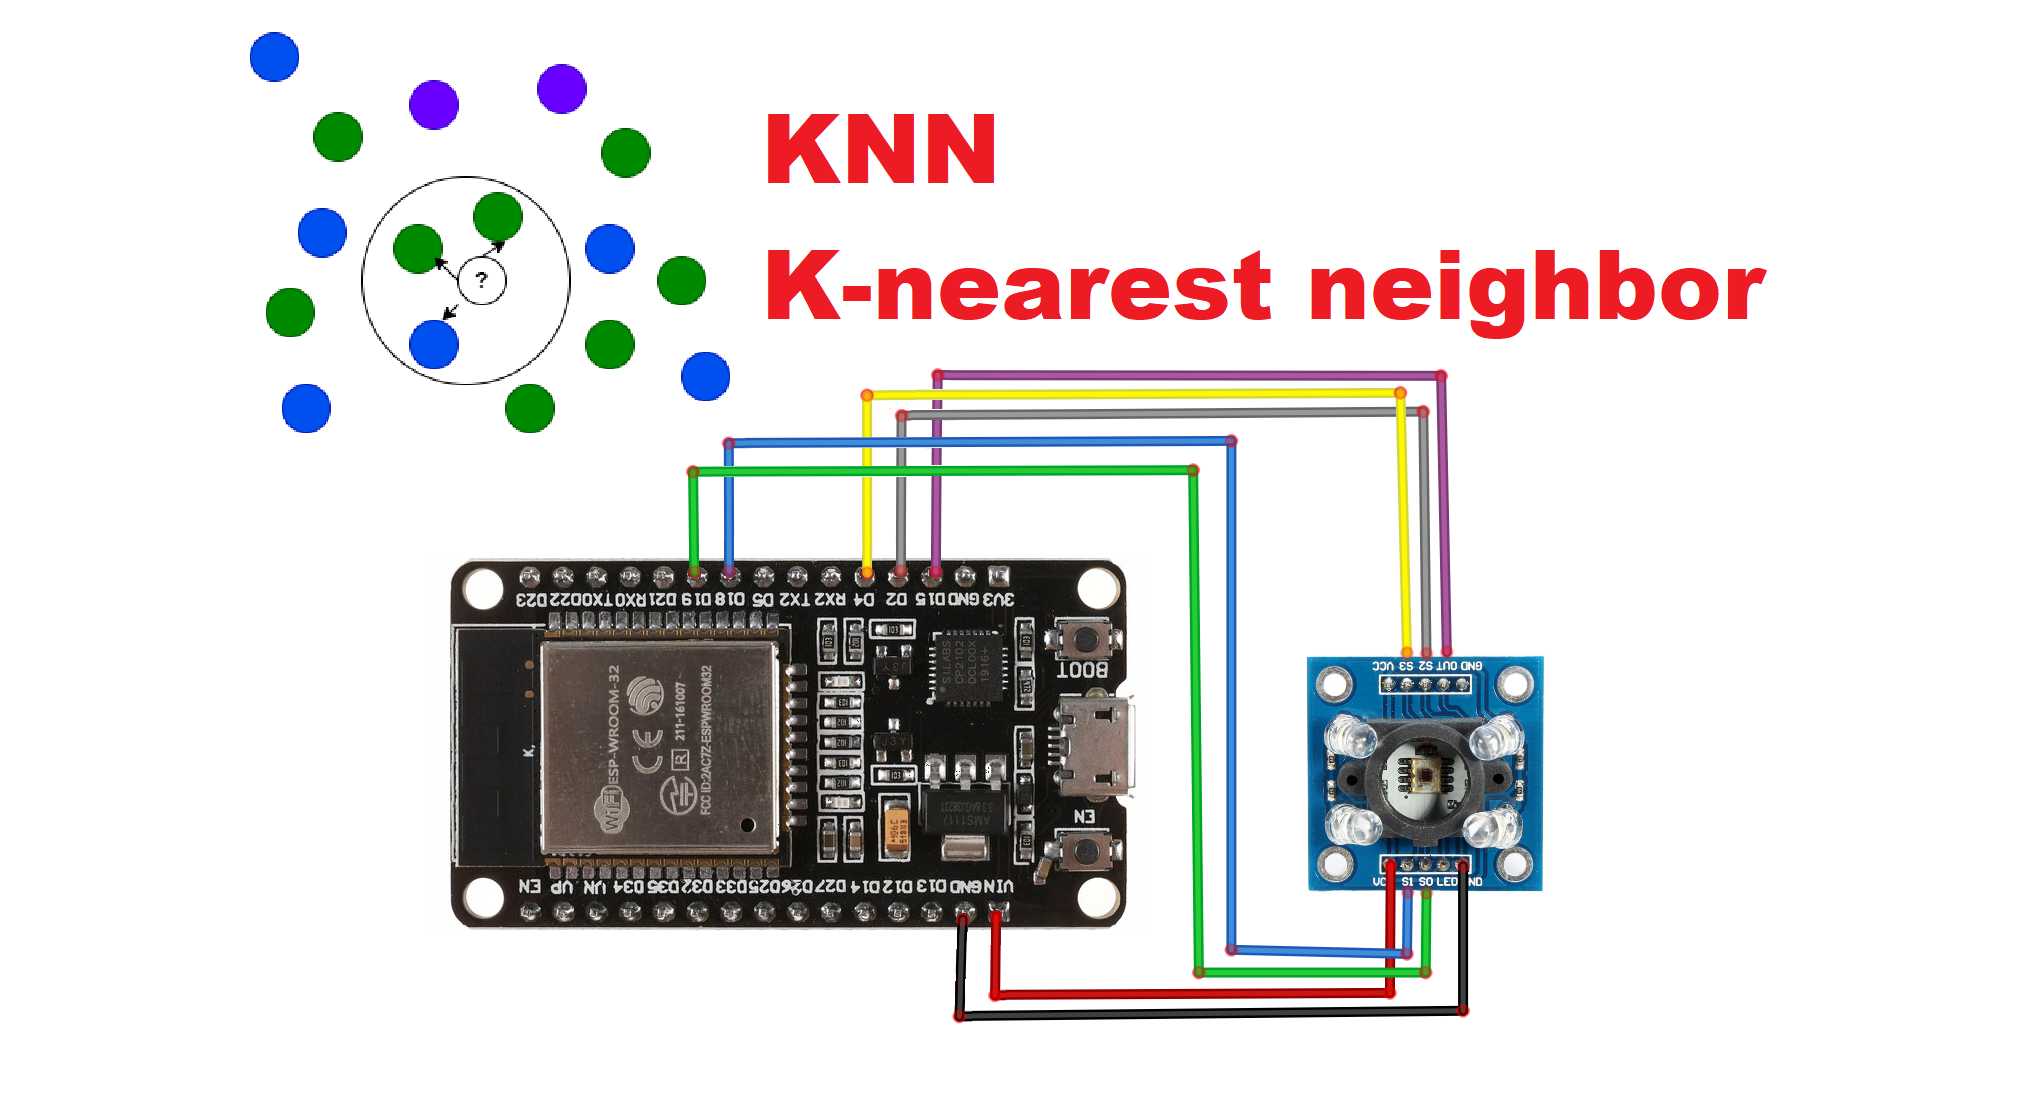

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Числовые признаки.
num_cols = [
    'RED',
    ' GREEN',
    ' BLUE',
    ' WHITE'
]

# Предсказываемый категориальный признак.
target_col = ' COLOR'

# Загрузим данные.
data = pd.read_csv('./DATASET_ESP32.txt')

# Посмотрим на 'n' случайных строчек
data.sample (n = 10)

RED   GREEN   BLUE   WHITE    COLOR   0 
15    7      14     16       3   Orange   16
22    8      11     16       3   Yellow   23
9    10      27     21       6      Red   10
59   15      26     14       6   Purple   60
35   19      17     21       6    Green   36
56   14      24     14       5   Purple   57
19    8      16     18       4   Orange   20
33   18      16     21       6    Green   34
23    8      10     15       3   Yellow   24
5     9      26     19       5      Red    6

## 3D график

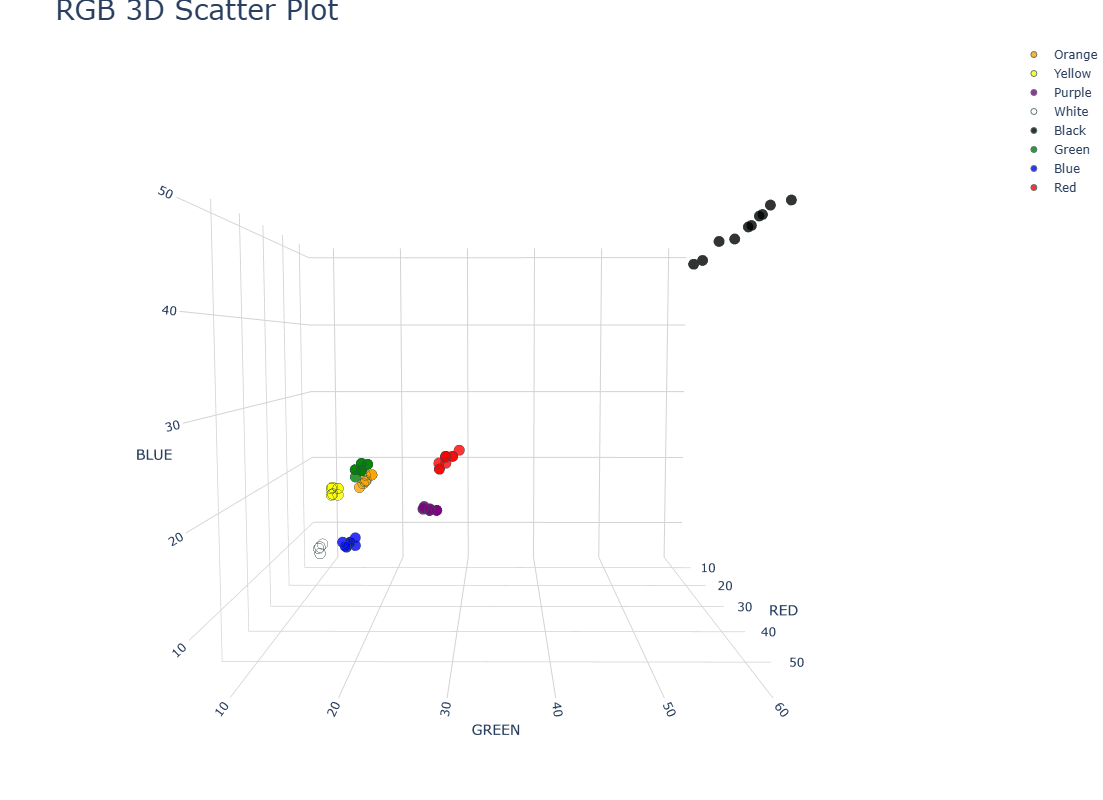

In [3]:
import plotly.graph_objects as go

colors = data[' COLOR'].str.strip()
fig = go.Figure()

color_map = {
    'Orange': 'orange',
    'Yellow': 'yellow',
    'Purple': 'purple',
    'White': 'white',
    'Black': 'black',
    'Green': 'green',
    'Blue': 'blue',
    'Red': 'red'
}

for color_name, plot_color in color_map.items():
    mask = colors == color_name
    fig.add_trace(go.Scatter3d(
        x=data.loc[mask, 'RED'],
        y=data.loc[mask, ' GREEN'],
        z=data.loc[mask, ' BLUE'],
        mode='markers',
        marker=dict(
            size=6,                # Сделать точки больше
            color=plot_color,
            opacity=0.8,            # Немного прозрачные
            line=dict(width=1, color='DarkSlateGrey')  # Обводка у точек
        ),
        name=color_name
    ))

fig.update_layout(
    scene=dict(
        xaxis_title='RED',
        yaxis_title='GREEN',
        zaxis_title='BLUE',
        xaxis=dict(backgroundcolor="white", gridcolor="lightgrey", showbackground=True),
        yaxis=dict(backgroundcolor="white", gridcolor="lightgrey", showbackground=True),
        zaxis=dict(backgroundcolor="white", gridcolor="lightgrey", showbackground=True),
    ),
    title=dict(text='RGB 3D Scatter Plot', font=dict(size=28)),
    width=1000,  # Больше ширина
    height=800,  # Больше высота
    margin=dict(l=0, r=0, b=0, t=40),  # Меньше отступы
    template='plotly_white'  # Светлая красивая тема
)

fig.show()

# Подготовка данных

In [4]:
# Признаки на которых будем обучать модель предсказывать цвет.
X_data = data[num_cols]
X_data.head(n=5)

RED   GREEN   BLUE   WHITE
0   10      28     21       6
1   10      28     21       5
2   10      26     20       5
3   11      27     21       6
4   11      29     22       6

### Масштабирование данных

Стандартизируем признаки, удалив из признака среднее значение $\mu_i$ и разделив на стандартное отклонение $\sigma_i$.

$$\mathbf{x_i}^{\text{new}} = \frac{\mathbf{x_i} - \mu_i}{\sigma_i}$$

**$\mu_i$ - среднее значение (***std_scaler.mean_***)**

$$\mu_i = \frac{1}{n} \sum_{j=1}^{n} x_{ij}$$

➊ $x_{ij}$ — значение признака i у объекта j

➋ $n$ — количество объектов

**$\sigma_i$ - стандартное отклонение (***std_scaler.scale_***)**

$$\sigma_i = \sqrt{\frac{1}{n - 1} \sum_{j=1}^{n} (x_{ij} - \mu_i)^2}$$

➊ $x_{ij}$ — значение признака i у объекта j

➋ $\mu_i$ — среднее значение признака i

➌ $n$ — количество объектов

In [5]:
from sklearn.preprocessing import StandardScaler

# Экземпляр обьекта для масштабирования данных.
std_scaler = StandardScaler()

# Расчитаем стандартное отклонение и среднее значение для всех признаков всего датасета.
std_scaler.fit(X_data.values)
std_scaler_mean = std_scaler.mean_
print(f'Среднее значение для признаков: {std_scaler_mean}')
std_scaler_scale = std_scaler.scale_
print(f'Стандартное отклонение для признаков: {std_scaler_scale}')

# Отмасштабированный датасет.
X_data_scaled = std_scaler.transform(X_data.values)

Среднее значение для признаков: [17.7875 21.775  19.1375  5.7875]
Стандартное отклонение для признаков: [14.87001492 14.88705394 11.70335823  4.21216616]


In [6]:
# Преобразуем в DataFrame
X_data_scaled = {'RED': X_data_scaled[:,0], 'GREEN': X_data_scaled[:,1], 'BLUE': X_data_scaled[:,2], 'WHITE': X_data_scaled[:,3]}
X_data_scaled = pd.DataFrame(data=X_data_scaled)

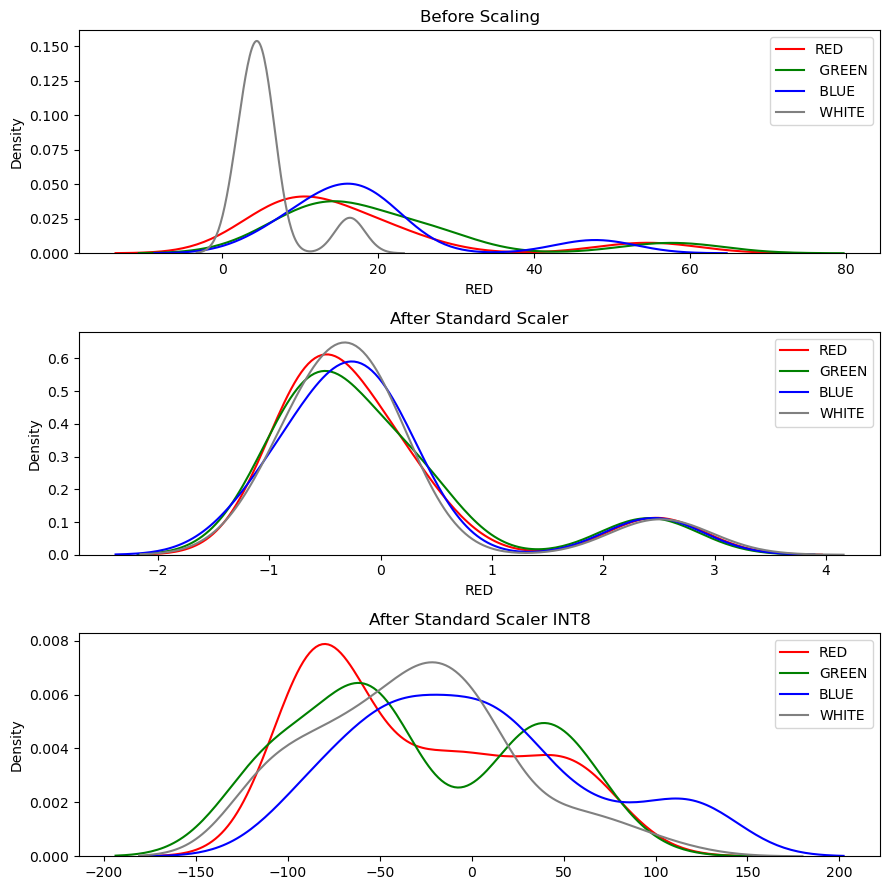

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Цвета для каждого признака
colors = ['red', 'green', 'blue', 'gray']  # настрой под свои признаки

# Создаём две подгруппы графиков
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 9))

# До масштабирования
for column, color in zip(X_data.columns, colors):
    sns.kdeplot(X_data[column], ax=ax1, label=column, color=color)
ax1.set_title('Before Scaling')
ax1.legend()

# После масштабирования
for column, color in zip(X_data_scaled.columns, colors):
    sns.kdeplot(X_data_scaled[column], ax=ax2, label=column, color=color)
ax2.set_title('After Standard Scaler')
ax2.legend()

# После масштабирования INT8
for column, color in zip(X_data_scaled.columns, colors):
    sns.kdeplot(np.int8(X_data_scaled[column]*127.5), ax=ax3, label=column, color=color)
ax3.set_title('After Standard Scaler INT8')
ax3.legend()

plt.tight_layout()
plt.show()

In [8]:
# Отмасштабированные признаки на которых будем обучать модель предсказывать цвет.
X_data_scaled.head(n=5)

RED     GREEN      BLUE     WHITE
0 -0.523705  0.418149  0.159142  0.050449
1 -0.523705  0.418149  0.159142 -0.186958
2 -0.523705  0.283804  0.073697 -0.186958
3 -0.456455  0.350976  0.159142  0.050449
4 -0.456455  0.485321  0.244588  0.050449

In [9]:
from sklearn.preprocessing import LabelEncoder

# Получим текстовые метки цвета из датафрейма.
Y_data_text = data[target_col]

# Заменим текстовые метки цвета на числовые.
Y_data_idx = LabelEncoder().fit_transform(Y_data_text)

# Отобразим соответствие текстовых меток числовым.
colors = pd.DataFrame({'COLOR': Y_data_text.values, 'IDX': Y_data_idx}).drop_duplicates()
colors

COLOR  IDX
0       Red    5
10   Orange    3
20   Yellow    7
30    Green    2
40     Blue    1
50   Purple    4
60    White    6
70    Black    0

In [13]:
from sklearn.model_selection import train_test_split

# Разделим датасет на две части (тренировочную и тестовую).
X_train, X_test, Y_train, Y_test = train_test_split(X_data_scaled.values, Y_data_idx, train_size = 0.75)

## KNN (K-ближайших соседей)
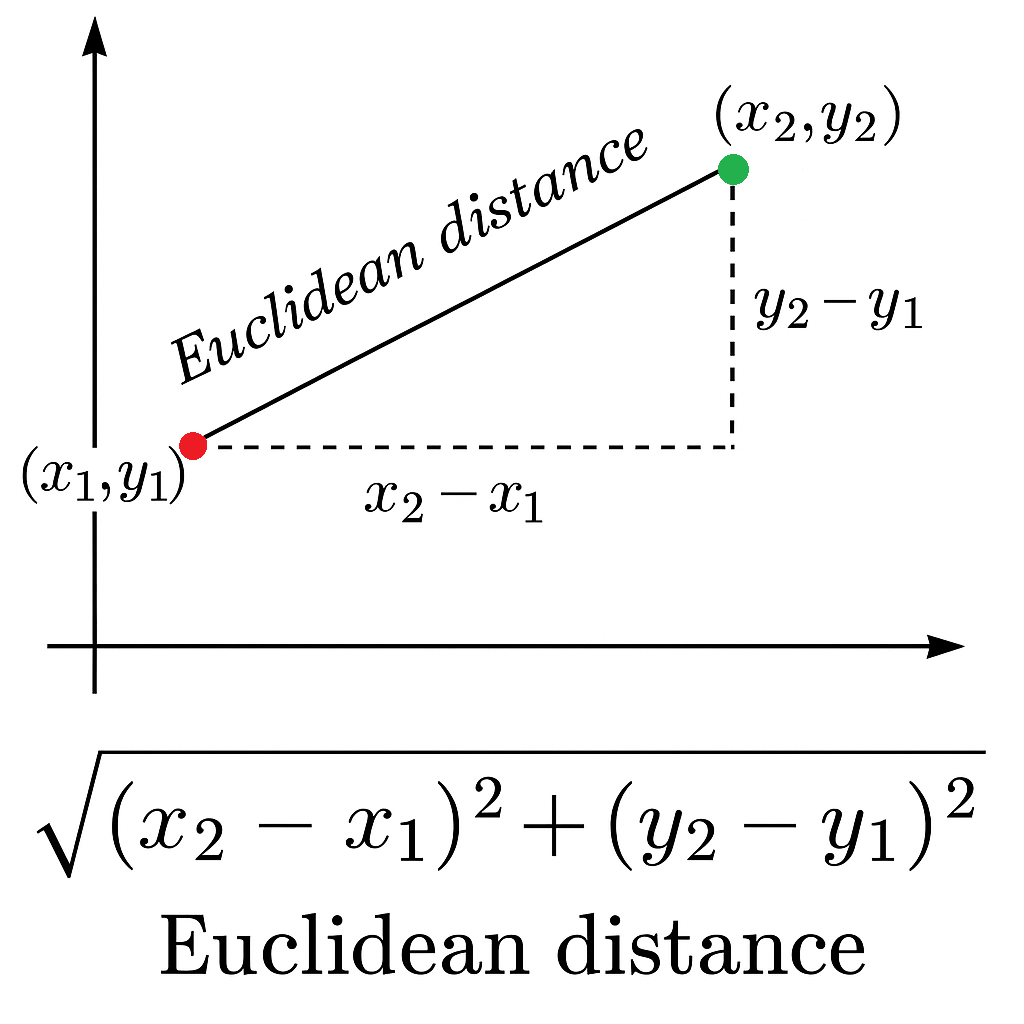
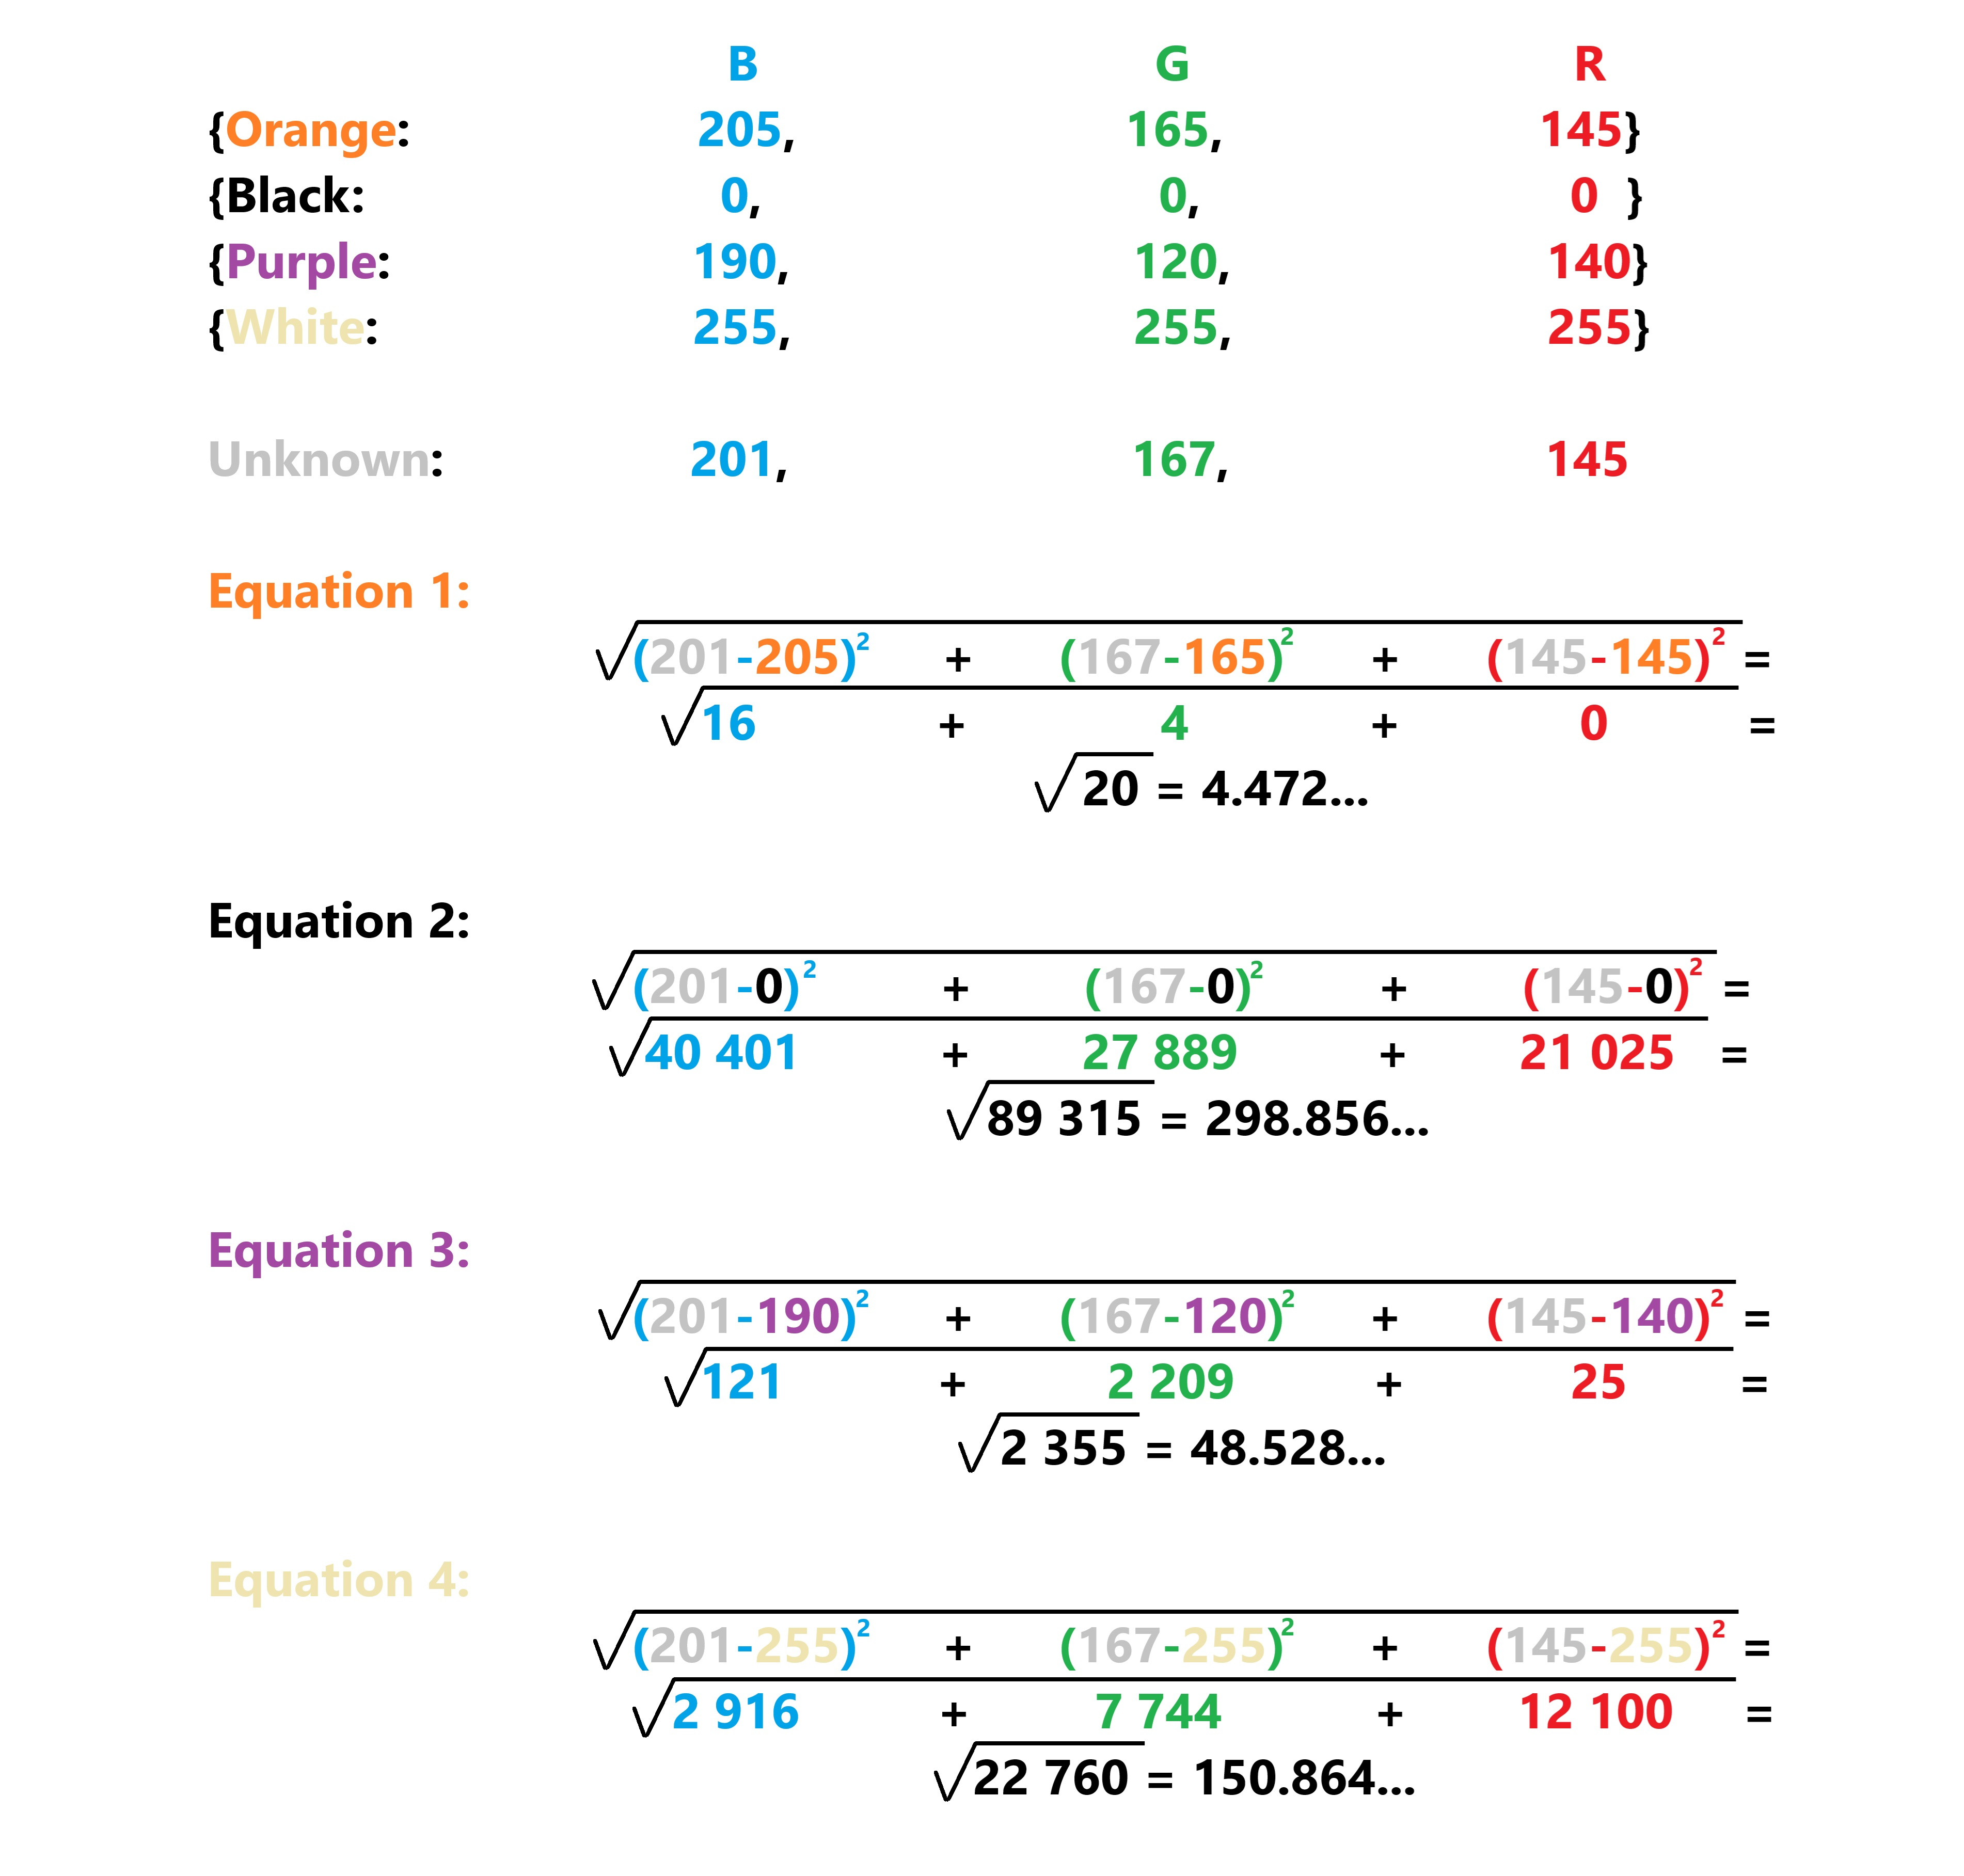

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# создание модели с указанием кол-ва ближайших соседей
clf = KNeighborsClassifier(n_neighbors=5)
# обучение модели
clf.fit(X_train, Y_train)
# предсказание на тестовой выборке
y_pred_knn = clf.predict(X_test)

print(y_pred_knn)

[4 2 0 5 0 1 6 2 2 4 6 7 3 4 3 6 7 3 2 6]


In [15]:
# Посчитаем точность предсказаний модели.
accuracy_score(Y_test, y_pred_knn)

1.0

### Массив наименований известных цветов для ESP32.

In [16]:
colorsArrayESP32 = 'const char* colors[] = {'
for c in colors['COLOR']:
    colorsArrayESP32 += '"' + c[1:] + '",'
colorsArrayESP32 = colorsArrayESP32[:-1] + '};'

colorsArrayESP32

'const char* colors[] = {"Red","Orange","Yellow","Green","Blue","Purple","White","Black"};'

### Массив содержащий стандартное отклонение и среднее значение каждой компоненты цвета для ESP32.

In [17]:
MeanAndScaleESP32 = 'Color MeanAndScale[] = {\n '

MeanAndScaleESP32 += '{" MEAN ", ' +  str(std_scaler_mean[0]) + ', ' + str(std_scaler_mean[1]) + ', ' + \
                                     str(std_scaler_mean[2]) +  ', ' + str(std_scaler_mean[3]) + '}, \n'

MeanAndScaleESP32 += ' {" SCALE ", ' + str(std_scaler_scale[0]) + ', ' + str(std_scaler_scale[1]) + ', ' + \
                                       str(std_scaler_scale[2]) + ', ' + str(std_scaler_scale[3]) + '}}; \n'

print(MeanAndScaleESP32)

Color MeanAndScale[] = {
 {" MEAN ", 17.7875, 21.775, 19.1375, 5.7875}, 
 {" SCALE ", 14.870014920974358, 14.887053939581197, 11.703358225312938, 4.212166158878351}}; 



### Отмасштабированный 'FLOAT' датасет из образцов цвета полученных с датчика для ESP32

In [18]:
# Датафрейм содержащий
scaledDataDF = pd.concat([X_data_scaled, pd.DataFrame({'COLOR': Y_data_text.values})], axis=1)

scaledFloatColorsArrayESP32 = 'Color knownColors[] = {\n'

for index, row in scaledDataDF.iterrows():
    color_name = row[4][1:]  # убираем первую кавычку

    scaledFloatColorsArrayESP32 += f'  {{"{color_name}", {row[0]}, {row[1]}, {row[2]}, {row[3]}}},\n'

scaledFloatColorsArrayESP32 = scaledFloatColorsArrayESP32[:-2] + '};'
print(scaledFloatColorsArrayESP32)

Color knownColors[] = {
  {"Red", -0.523704921708964, 0.4181485487500775, 0.1591423559070114, 0.05044910195484466},
  {"Red", -0.523704921708964, 0.4181485487500775, 0.1591423559070114, -0.18695843665618864},
  {"Red", -0.523704921708964, 0.28380363348900844, 0.07369679568848182, -0.18695843665618864},
  {"Red", -0.4564554935601403, 0.350976091119543, 0.1591423559070114, 0.05044910195484466},
  {"Red", -0.4564554935601403, 0.48532100638061204, 0.24458791612554096, 0.05044910195484466},
  {"Red", -0.5909543498577875, 0.28380363348900844, -0.011748764530047756, -0.18695843665618864},
  {"Red", -0.523704921708964, 0.350976091119543, 0.1591423559070114, 0.05044910195484466},
  {"Red", -0.5909543498577875, 0.28380363348900844, -0.011748764530047756, -0.18695843665618864},
  {"Red", -0.523704921708964, 0.350976091119543, 0.07369679568848182, -0.18695843665618864},
  {"Red", -0.523704921708964, 0.350976091119543, 0.1591423559070114, 0.05044910195484466},
  {"Orange", -0.6582037780066111, -0.3

### Отмасштабированный 'INT8' датасет из образцов цвета полученных с датчика для ESP32

In [19]:
scaledINT8ColorsArrayESP32 = 'Color knownColors[] = {\n'

for index, row in scaledDataDF.iterrows():
    color_name = row[4][1:]

    scaledINT8ColorsArrayESP32 += f'  {{"{color_name}", {np.int8(row[0]*127.5)}, {np.int8(row[1]*127.5)}, {np.int8(row[2]*127.5)}, {np.int8(row[3]*127.5)}}},\n'

scaledINT8ColorsArrayESP32 = scaledINT8ColorsArrayESP32[:-2] + '};'
print(scaledINT8ColorsArrayESP32)

Color knownColors[] = {
  {"Red", -66, 53, 20, 6},
  {"Red", -66, 53, 20, -23},
  {"Red", -66, 36, 9, -23},
  {"Red", -58, 44, 20, 6},
  {"Red", -58, 61, 31, 6},
  {"Red", -75, 36, -1, -23},
  {"Red", -66, 44, 20, 6},
  {"Red", -75, 36, -1, -23},
  {"Red", -66, 44, 9, -23},
  {"Red", -66, 44, 20, 6},
  {"Orange", -83, -49, -12, -54},
  {"Orange", -92, -58, -23, -54},
  {"Orange", -83, -58, -23, -54},
  {"Orange", -66, -58, -23, -54},
  {"Orange", -83, -58, -23, -54},
  {"Orange", -92, -66, -34, -84},
  {"Orange", -83, -58, -23, -54},
  {"Orange", -83, -58, -12, -54},
  {"Orange", -83, -49, -12, -54},
  {"Orange", -83, -49, -12, -54},
  {"Yellow", -83, -92, -34, -84},
  {"Yellow", -83, -100, -34, -84},
  {"Yellow", -83, -92, -34, -84},
  {"Yellow", -83, -100, -45, -84},
  {"Yellow", -92, -100, -34, -84},
  {"Yellow", -83, -100, -34, -84},
  {"Yellow", -83, -92, -45, -84},
  {"Yellow", -92, -100, -45, -84},
  {"Yellow", -92, -100, -45, -84},
  {"Yellow", -83, -92, -34, -84},
  {"Green", 

**Преобразование float в int8 для ESP32**


int8_t value = (int8_t)(row0 * 127.5);

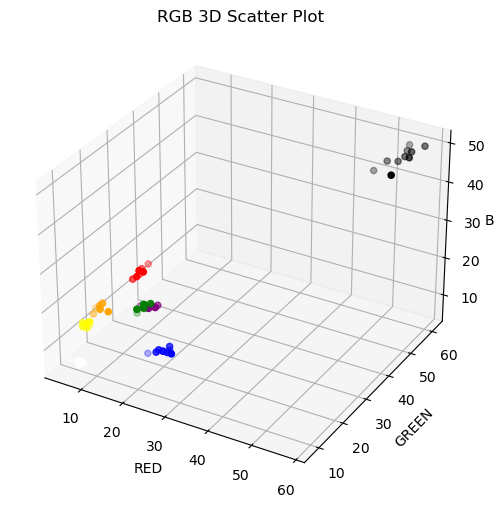

In [20]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

# Координаты для осей (RGB компоненты).
X_r = data[['RED', ' COLOR']]
Y_g = data[[' GREEN', ' COLOR']]
Z_b = data[[' BLUE', ' COLOR']]

# Создать фигуру и 3D-ось.
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Создать диаграмму рассеяния.
ax.scatter(X_r[X_r[' COLOR']==' Orange']['RED'], Y_g[Y_g[' COLOR']==' Orange'][' GREEN'], Z_b[Z_b[' COLOR']==' Orange'][' BLUE'], color='orange')
ax.scatter(X_r[X_r[' COLOR']==' Yellow']['RED'], Y_g[Y_g[' COLOR']==' Yellow'][' GREEN'], Z_b[Z_b[' COLOR']==' Yellow'][' BLUE'], color='yellow')
ax.scatter(X_r[X_r[' COLOR']==' Purple']['RED'], Y_g[Y_g[' COLOR']==' Purple'][' GREEN'], Z_b[Z_b[' COLOR']==' Purple'][' BLUE'], color='purple')
ax.scatter(X_r[X_r[' COLOR']==' White']['RED'], Y_g[Y_g[' COLOR']==' White'][' GREEN'], Z_b[Z_b[' COLOR']==' White'][' BLUE'], color='white')
ax.scatter(X_r[X_r[' COLOR']==' Black']['RED'], Y_g[Y_g[' COLOR']==' Black'][' GREEN'], Z_b[Z_b[' COLOR']==' Black'][' BLUE'], color='black')
ax.scatter(X_r[X_r[' COLOR']==' Green']['RED'], Y_g[Y_g[' COLOR']==' Green'][' GREEN'], Z_b[Z_b[' COLOR']==' Green'][' BLUE'], color='green')
ax.scatter(X_r[X_r[' COLOR']==' Blue']['RED'], Y_g[Y_g[' COLOR']==' Blue'][' GREEN'], Z_b[Z_b[' COLOR']==' Blue'][' BLUE'], color='blue')
ax.scatter(X_r[X_r[' COLOR']==' Red']['RED'], Y_g[Y_g[' COLOR']==' Red'][' GREEN'], Z_b[Z_b[' COLOR']==' Red'][' BLUE'], color='red')

# Метки.
ax.set_xlabel('RED')
ax.set_ylabel('GREEN')
ax.set_zlabel('BLUE')
ax.set_title('RGB 3D Scatter Plot')

plt.show()